# Basic correction and evaluation

This example corrects a small set of aerial images and evaluates the results.  

Images are taken from the `homonim` test data: Aerials were obtained from [NGI](https://ngi.dalrrd.gov.za/), and subsequently downsampled and re-scaled to *uint8* precision to reduce size.  Satellite images were acquired with [geedim](https://github.com/dugalh/geedim), and re-scaled to *uint8* precision.  

The notebook uses the APIs of `homonim` and other packages.  CLI commands equivalent to the API code snippets are given in the comments where possible.


## Setup

`gdal` and `matplotlib` are required to run the notebook.  You can uncomment the cell below to install them, if they aren't installed already.

In [1]:
# matplotlib and gdal should be installed if they aren't already.
# import sys
# if 'conda' in sys.prefix:
#     # install into the conda environment the notebook is being run from
#     !conda install --yes --prefix {sys.prefix} -c conda-forge gdal matplotlib
# else:
#     # install into the python environment the notebook is being run from
#     !{sys.executable} -m pip install gdal matplotlib

In [2]:
import logging
from pathlib import Path
from matplotlib import pyplot
import rasterio as rio
from rasterio.plot import show
import numpy as np
from homonim import RasterFuse, RasterCompare, Model

logging.basicConfig(level=logging.ERROR)

In [3]:
# create URLS of homonim source and reference images.
src_paths = [
    f'https://raw.githubusercontent.com/dugalh/homonim/main/'
    f'tests/data/source/ngi_rgb_byte_{i}.tif' 
    for i in range(1, 5)
]
ref_path = (
    'https://raw.githubusercontent.com/dugalh/homonim/main/'
    'tests/data/reference/sentinel2_b432_byte.tif'
)

## Surface reflectance correction

Here we fuse the aerial images with a Sentinel-2 reference, using the `RasterFuse` class.  Source and reference images are RGB, so bands are [matched automatically](../cli.rst#band-matching), and there is no need to specify the `src_bands` or `ref_bands` parameters. Fusion uses the *gain-blk-offset* [model](../background.rst#model), with a [kernel shape](../background.rst#kernel-shape) of 5x5 pixels. These standard settings work reasonably well in a variety of contexts, including this example.

In [4]:
# corrected file names corresponding to source names
corr_paths = [f'corr_{Path(src_path).stem}.tif' for src_path in src_paths]

for src_path, corr_path in zip(src_paths, corr_paths):
    with RasterFuse(src_path, ref_path) as raster_fuse:
        raster_fuse.process(
            corr_path, Model.gain_blk_offset, (5, 5), overwrite=True
        )

    # equivalent homonim command line:
    # !homonim fuse -m gain-blk-offset -k 5 5 -o {src_path} {ref_path}


  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

## Visualisation

Next, we create a [VRT](https://gdal.org/drivers/raster/vrt.html) mosaic of the corrected images that will be used here, and in the evaluation step.

In [5]:
# strictly, one should avoid using GDAL and rasterio together, but it doesn't
# create conflicts here
from osgeo import gdal

corr_mosaic_path = 'corr_ngi_mosaic_rgb_byte.vrt'
ds = gdal.BuildVRT(corr_mosaic_path, corr_paths)
ds.FlushCache()

Now we can display a zoomed-in area of the source mosaic, reference image and corrected mosaic.

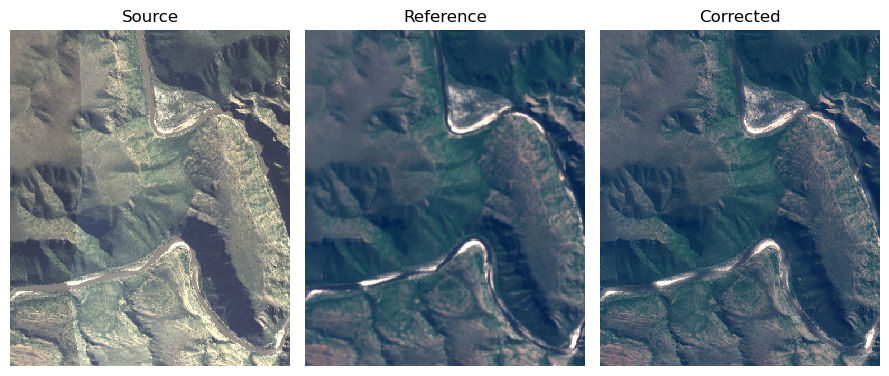

In [6]:
# VRT mosaic of the source files
src_mosaic_path = (
    'https://raw.githubusercontent.com/dugalh/homonim/main/'
    'tests/data/source/ngi_mosaic_rgb_byte.vrt'
)

fig, axes = pyplot.subplots(
    1, 3, sharex=True, sharey=True, tight_layout=True, figsize=(9, 4), dpi=100
)

# loop over the source, reference and corrected images etc
for im_file, scale, ax, label in zip(
    [src_mosaic_path, ref_path, corr_mosaic_path],
    [255, 150, 150],
    axes,
    ['Source', 'Reference', 'Corrected'], 
):   
    # read, scale and display the image
    with rio.open(im_file, 'r') as ds:
        array = ds.read(out_dtype='float32') / scale
        
        show(array, transform=ds.transform, ax=ax, interpolation='nearest')

    ax.set_title(label)
    ax.set_xlim(-5.75e4, -5.50e4)  # zoom in
    ax.set_ylim(-3.733e6, -3.730e6) 
    ax.axis('off')

# fig.savefig('../case_studies/basic_correction-src_ref_corr.jpg', dpi=150)

Correction has removed a visible seamline between images in the source mosaic, and the corrected and reference surface reflectances are visually similar.  

## Evaluation

In this last section, we compare the source and corrected similarity with another reference.  The comparison gives an indication of the change in surface reflectance accuracy due to correction.  Rather than compare with the Sentinel-2 reference used for correction, we compare with an independent Landsat-8 reference.  This avoids positively biasing the accuracy estimates in the case of overfitting. 

As a first step, we use `RasterCompare` to produce tables of comparison statistics.

In [7]:
# URL of the Landsat-8 reference
cmp_ref_path = (
    'https://raw.githubusercontent.com/dugalh/homonim/main/'
    'tests/data/reference/landsat8_byte.tif'
)
print(RasterCompare.schema_table())

# loop over the source and corrected image files
for im_path, im_label in zip(
    [src_mosaic_path, corr_mosaic_path],
    ['Source', 'Corrected'],
):
    with RasterCompare(im_path, cmp_ref_path) as compare:
        # print a table of comparison statistics (the typical way of using 
        # RasterCompare)
        stats_dict = compare.process()
        print(f'{im_label} comparison:\n\n' + compare.stats_table(stats_dict))

    # equivalent homonim command line:
    # !homonim compare {im_path} {cmp_ref_path}

ABBREV   DESCRIPTION
-------- -----------------------------------------
r²       Pearson's correlation coefficient squared
RMSE     Root Mean Square Error
rRMSE    Relative RMSE (RMSE/mean(ref))
N        Number of pixels


  0%|                                                                                                         …

Source comparison:

  Band    r²   RMSE   rRMSE     N
------ ----- ------ ------- -----
 SR_B4 0.639 79.247   1.746 76143
 SR_B3 0.549 83.168   1.859 76143
 SR_B2 0.409 94.104   3.169 76143
  Mean 0.533 85.506   2.258 76143


  0%|                                                                                                         …

Corrected comparison:

  Band    r²   RMSE   rRMSE     N
------ ----- ------ ------- -----
 SR_B4 0.938  9.815   0.216 76143
 SR_B3 0.922  6.892   0.154 76143
 SR_B2 0.862 30.966   1.043 76143
  Mean 0.907 15.891   0.471 76143


The tables (and $r^2$ values in particular) show that correction has improved similarity with the Landsat-8 reference.  

Next, we use `RasterCompare` again, but this time to read spatially matching bands from the source / corrected - reference pairs.  Scatter plots of source / corrected vs. reference surface reflectance are created from these bands.

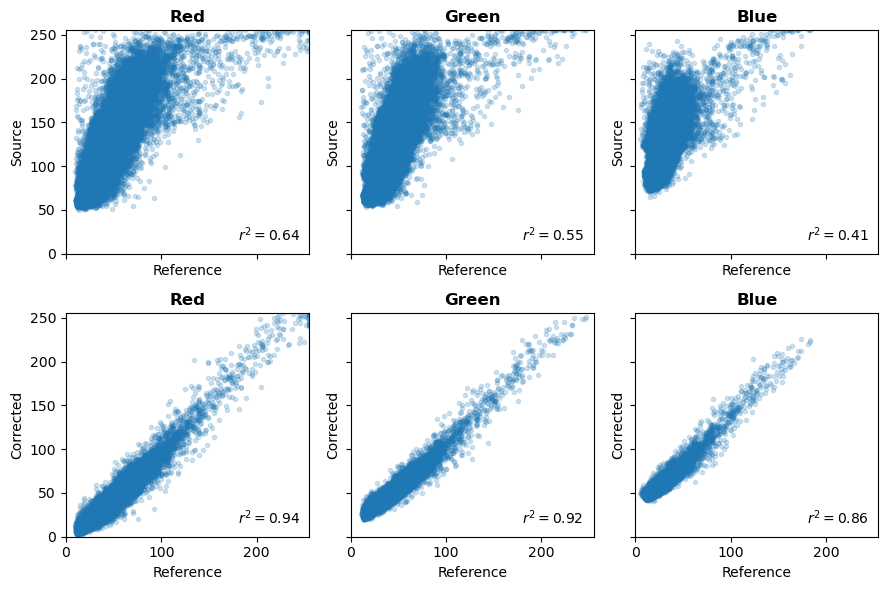

In [8]:
fig, axes = pyplot.subplots(
    2, 3, sharex=True, sharey=True, tight_layout=True, figsize=(9, 6), dpi=100
)

# loop over the source and corrected image files and corresponding axes etc
for im_i, im_path, im_label in zip(
    range(2),
    [src_mosaic_path, corr_mosaic_path],
    ['Source', 'Corrected'],
):
    with RasterCompare(im_path, cmp_ref_path) as compare:
        # loop over band pairs to produce surface reflectance scatter plots. 
        # (Note that RasterCompare.block_pairs without arguments returns 
        # 'blocks' that encompass bands.)
        for band_i, block_pair, band_label in zip(
            range(3),
            compare.block_pairs(),
            ['Red', 'Green', 'Blue']
        ):
            # read source/corrected - reference band pair, and reproject the 
            # source/corrected band to the reference CRS and pixel grid
            src_ra, ref_ra = compare.read(block_pair)
            src_ra = src_ra.reproject(
                **ref_ra.proj_profile, resampling='average'
            )

            # make vectors of valid pixels in the source/corrected and reference 
            # bands
            mask = src_ra.mask & ref_ra.mask  # mask of valid pixels
            src_v, ref_v = src_ra.array[mask], ref_ra.array[mask]

            # find r2 and create scatter plot
            r2 = np.corrcoef(src_v, ref_v)[0, 1] ** 2 
            ax = axes[im_i, band_i]
            ax.plot(ref_v, src_v, '.', alpha=0.2)
            ax.set_xlim(0, 255)
            ax.set_ylim(0, 255)
            ax.text(180, 15, f'$r^2={r2:.2f}$', fontweight='bold')
            ax.set_xlabel('Reference')
            ax.set_ylabel(im_label)
            ax.set_title(band_label, fontweight='bold')

# fig.savefig('../case_studies/basic_correction-eval.png', dpi=100)

Again, the scatter plots show a useful improvement after correction.  Improvement in similarity with the Landsat-8 reference likely corresponds to a similar improvement in surface reflectance accuracy.